In [ ]:
import torch
import pickle

# Load sharding.pkl
with open('sharding.pkl', 'rb') as f:
    interval_dict = pickle.load(f)

In [ ]:
import pickle
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [ ]:
models = {}
interval = 25

for k in interval_dict.keys():
    start = k
    end = start + interval
    
    if torch.cuda.is_available():
        shard = CPU_Unpickler(open(f'models_{start}_{end}.pkl', 'rb')).load()
    else:
        shard = pickle.load(open(f'models_{start}_{end}.pkl', 'rb'))
    
    for key in shard.keys():
        if shard[key] is not None:
            models[key] = shard[key].to('cpu')
            
# Save the models dictionary to a file
with open('all_models.pkl', 'wb') as f:
    pickle.dump(models, f)

In [ ]:
# Set the seed
seed = 2
torch.manual_seed(seed)
batch_size = 64

# First thing to do is load the data
_, data = pickle.load(open("./glove/kmeans_clusters_500.pkl", "rb"))

# Checks if GPU(s) are available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X, labels = None, None
for k in data.keys():
    if X is None:
        X = torch.Tensor(data[k])
        labels = torch.reshape(torch.Tensor([k] * len(data[k])), (-1, 1))
    else:
        X = torch.cat([X, torch.Tensor(data[k])])
        temp = torch.reshape(torch.Tensor([k] * len(data[k])), (-1, 1))
        labels = torch.cat([labels, temp])

# Construct the set of unique labels
targets = [x.item() for x in labels]
unique_labels = list(set(targets))



In [ ]:
X.requires_grad = True
explanations = {}

# k = unique_labels[0]
for k in unique_labels:
    print("Explaining model for class", k)

    # Move both the model and data onto `device`
    model = models[k].to(device)
    X = X.to(device)

    predictions = model.forward(X, explain=True, rule="alpha2beta1")
    predictions = predictions.sum()
    predictions.backward()
    
    print(predictions)
    print(X.grad)

    explanation = X.grad
    explanations[k] = explanation

# Save the explanations
pickle.dump(explanations, open("explanations.pkl", "wb"))

In [ ]:
from PCA import extract_pca_features
import pickle
import numpy as np
import torch

labels = [0, 1, 6, 12, 16, 16, 176, 492]
# Extract the PCA features from each pickle and save as pickles
pca_features = {}

for l in labels:
    print("Extracting PCA features for class", l)
    # Load the explanations
    explanations = pickle.load(open(f"evidence_{l}.pkl", "rb"))
    tensed = torch.tensor([])
    for vec in explanations:
        if vec.shape[0] == 63:
            # Pad it with zeros
            vec = torch.cat([vec, torch.zeros(1, 50)])
        tensed = torch.cat([tensed, torch.tensor(vec).unsqueeze(0)])
    # explanations = explanations.to('cpu')
    # Reshape tensed to be of shape (n, 50)
    tensed = tensed.reshape(-1, 50)
    pca_features[l] = extract_pca_features(tensed, threshold=2)
    print("PCA features extracted for class", l)
    
pickle.dump(pca_features, open("pca_features.pkl", "wb"))

In [ ]:
for i in range(500):
    print((explanations[0] == explanations[i]).all())

In [1]:
import pickle
import numpy as np

# Load the PCA features
pca_features = pickle.load(open("pca_features.pkl", "rb"))

for k in pca_features.keys():
    print(pca_features[k])

[[ 0.13400569  0.11195415  0.08432978  0.09873781  0.07627899  0.0600232
   0.09515968  0.10914276  0.09732029  0.08751271  0.04626503  0.04620448
   0.24496264  0.2042281   0.1009865   0.17078281  0.04434697  0.13357617
   0.08319672  0.09071262  0.12612509  0.07228666  0.15078955  0.0730603
   0.08164295  0.15420523  0.04732907  0.05524682  0.04912923  0.10012849
   0.71037373  0.07671321  0.04834079  0.07647013  0.05584965  0.06221245
   0.05920547  0.09421844  0.07759955  0.06597249  0.07587608  0.06919745
   0.09062194  0.07919592  0.07112325  0.18589114  0.02655654  0.08507092
   0.0644252   0.04739185]
 [-0.13371475 -0.05305431 -0.07681324 -0.09456247 -0.06549698 -0.04759746
  -0.07872692 -0.11933641 -0.05004081 -0.08496098 -0.04835797 -0.07026377
  -0.35809322 -0.17730093 -0.09836124 -0.17726531 -0.04106764 -0.11232173
  -0.09005524 -0.10642773 -0.08497438 -0.02599669 -0.14264964 -0.05679721
  -0.12913762 -0.14230738 -0.05440266 -0.06294465 -0.05488081 -0.13344616
   0.6877563 

In [ ]:
# load 50d glove embeddings
with open('glove/glove_50d.pkl', 'rb') as f:
    glove_50d = pickle.load(f)

print(len(glove_50d))

# reverse the mapping
glove_50d_inv = {tuple(v): k for k, v in glove_50d.items()}

62143
Class 0
Class 1
Class 6
Class 12
Class 16


/var/folders/kg/8rw13j991l36qb68sz4mp8qc0000gn/T/ipykernel_50860/3463793558.py:68: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"./images/glove_{k}.png", dpi=500)


Class 176
Class 492


/var/folders/kg/8rw13j991l36qb68sz4mp8qc0000gn/T/ipykernel_50860/3463793558.py:59: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"./images/pca_{k}.png", dpi=500)
/Users/avinewatia/miniconda3/envs/CSC413/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


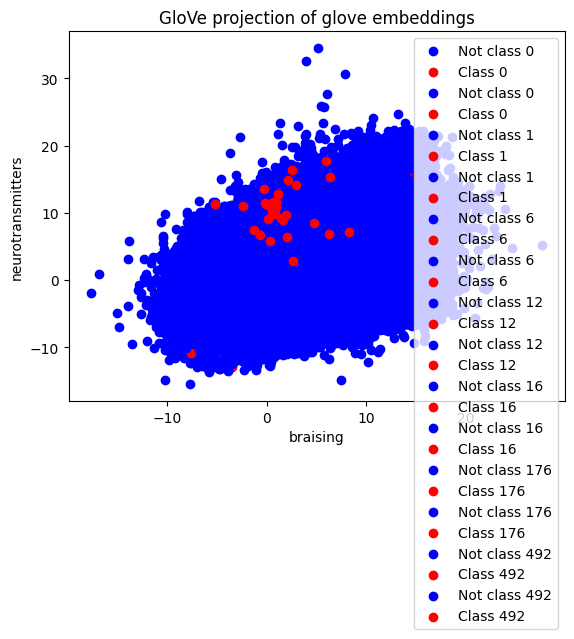

In [9]:
from sklearn.metrics import pairwise_distances
# from sklearn.metrics.pairwise import cosine_similarity
import torch

words, vectors = pickle.load(open("glove/kmeans_clusters_500.pkl", "rb"))

with open('glove/glove_50d.pkl', 'rb') as f:
    glove_50d = pickle.load(f)

print(len(glove_50d))

# reverse the mapping
glove_50d_inv = {tuple(v): k for k, v in glove_50d.items()}

X = torch.tensor([])
targets = torch.tensor([])

for k in vectors.keys():
    X = torch.cat([X, torch.tensor(vectors[k])])
    targets = torch.cat([targets, torch.tensor([k] * len(vectors[k]))])

for k in pca_features.keys():
    print("Class", k)
    
    dims = pca_features[k]
    
    # Find the closest glove words to the PCA dimensions
    closest_words = []
    closest_vectors = []
    vals = list(glove_50d.values())
    for i in range(dims.shape[0]):
        distances = []
        for j in range(len(glove_50d.values())):
            distances.append(torch.abs(torch.cosine_similarity(torch.tensor(dims[i]), torch.tensor(vals[j]), dim=0).cpu()))
        closest_idx = np.argmax(distances)
        closest_words.append(glove_50d_inv[tuple(vals[closest_idx])])
        closest_vectors.append(vals[closest_idx])
    
    one_hot = [1 if x == k else 0 for x in targets]
    
    # Project X onto the PCA dimensions
    X_proj = X @ dims.T
    X_glove_proj = X @ torch.tensor(closest_vectors).T
    
    X_proj_0 = X_proj[torch.tensor(one_hot) == 0]
    X_proj_1 = X_proj[torch.tensor(one_hot) == 1]
    
    X_glove_proj_0 = X_glove_proj[torch.tensor(one_hot) == 0]
    X_glove_proj_1 = X_glove_proj[torch.tensor(one_hot) == 1]
    
    # Plot
    import matplotlib.pyplot as plt
    plt.scatter(X_proj_0[:, 0], X_proj_0[:, 1], c='b', label='Not class ' + str(k))
    plt.scatter(X_proj_1[:, 0], X_proj_1[:, 1], c='r', label='Class ' + str(k))
    plt.title("PCA projection of glove embeddings")
    plt.xlabel("PCA dimension 1")
    plt.ylabel("PCA dimension 2")
    plt.legend()
    plt.savefig(f"./images/pca_{k}.png", dpi=500)
    # plt.show()
    
    plt.scatter(X_glove_proj_0[:, 0], X_glove_proj_0[:, 1], c='b', label='Not class ' + str(k))
    plt.scatter(X_glove_proj_1[:, 0], X_glove_proj_1[:, 1], c='r', label='Class ' + str(k))
    plt.title("GloVe projection of glove embeddings")
    plt.xlabel(closest_words[0])
    plt.ylabel(closest_words[1])
    plt.legend()
    plt.savefig(f"./images/glove_{k}.png", dpi=500)
    # plt.show()

In [13]:
words, vectors = pickle.load(open("glove/kmeans_clusters_500.pkl", "rb"))

with open('glove/glove_200d.pkl', 'rb') as f:
    glove_50d = pickle.load(f)

print(len(glove_50d))

# reverse the mapping
glove_50d_inv = {tuple(v): k for k, v in glove_50d.items()}

beetroot = glove_50d["beetroot"]

opposite_beetroot = -beetroot

distances = []
for k in glove_50d.keys():
    distances.append((torch.cosine_similarity(torch.tensor(opposite_beetroot), torch.tensor(glove_50d[k]), dim=0).cpu()))
    
closest_idx = np.argmax(distances)
print(glove_50d_inv[tuple(list(glove_50d.values())[closest_idx])])

77048
reached
